# Forest Fires (Anna)
- https://archive.ics.uci.edu/ml/datasets/Forest+Fires
- medium samples (513), small dimension (13)
- attribute characteristics: numeric, categorical
- Predict: area
- Missing values: No

## Preprocessing
- Convert 'month', 'day' to numeric variables 
- log transformation (log(1+area)) was applied to response variable 'area' since highly right skewed


### Linear Regression
- unscaled data
- results:
    - <1 s
    - R^2: 0.07451358850565404
    - RMSE: 1.43211

- scaled data
- results:
    - <1 s
    - R^2: 0.07451358850565404
    - RMSE: 1.43211
    
### SVR
- unscaled data
- results
    - too long
    
- scaled data
- results
    - few seconds
    - {'C': 0.8, 'epsilon': 0.5, 'kernel': 'rbf'}
    - RMSE: 1.41865
    
### Gradient Boosted Decision Tree
- scaled data
- results:
    - 67.832 s
    - {'max_depth': 1, 'min_samples_split': 5, 'n_estimators': 150}
    - RMSE: 1.35524
    
### AutoML
- max_models=30, max_runtime_secs=300:
    - Model: GLM_grid_1_AutoML_20190106_184723_model_1
    - RMSE: 1.36861
    
- max_models=50, max_runtime_secs=600:
    - Model: GLM_grid_1_AutoML_20190106_184723_model_1
    - RMSE: 1.36861
    
    GLM_grid_1_AutoML_20190106_192136_model_1	

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import time
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from time import strptime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import math
from sklearn.decomposition import PCA
import h2o
from h2o.automl import H2OAutoML

#%run './base.ipynb'

/Users/annanau/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Import Data
Data contains no missing values. Features 'month', 'day' are dtype object.

In [3]:
## import data 
data = pd.read_csv('/Users/annanau/Documents/Workspace/ML_Ex2/data/forest_fires/forestfires.csv')
#display(data.isna().sum()) 
#data.info()
print(data.head(10))

   X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.0
5  8  6   aug  sun  92.3   85.3  488.0  14.7  22.2  29   5.4   0.0   0.0
6  8  6   aug  mon  92.3   88.9  495.6   8.5  24.1  27   3.1   0.0   0.0
7  8  6   aug  mon  91.5  145.4  608.2  10.7   8.0  86   2.2   0.0   0.0
8  8  6   sep  tue  91.0  129.5  692.6   7.0  13.1  63   5.4   0.0   0.0
9  7  5   sep  sat  92.5   88.0  698.6   7.1  22.8  40   4.0   0.0   0.0


# Visualizing/Exploring/Preprocessing
- data contains no missing values
- 'month', 'day' are dtype object, need to be made numeric
- log transformation was applied to response variable 'area' since highly right skewed (R^2 was increased by ~%4)

In [4]:
## Convert 'month', 'day' to numeric variables 
data2 = data
data2['month'] = pd.to_datetime(data['month'], format = '%b').dt.month
data2['day'] = data['day'].apply(lambda x: time.strptime(x, '%a')).apply(lambda x: x.tm_wday)

#data2.info()
#data2.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,3.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,1.000000,0.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,1.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,9.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,12.000000,6.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


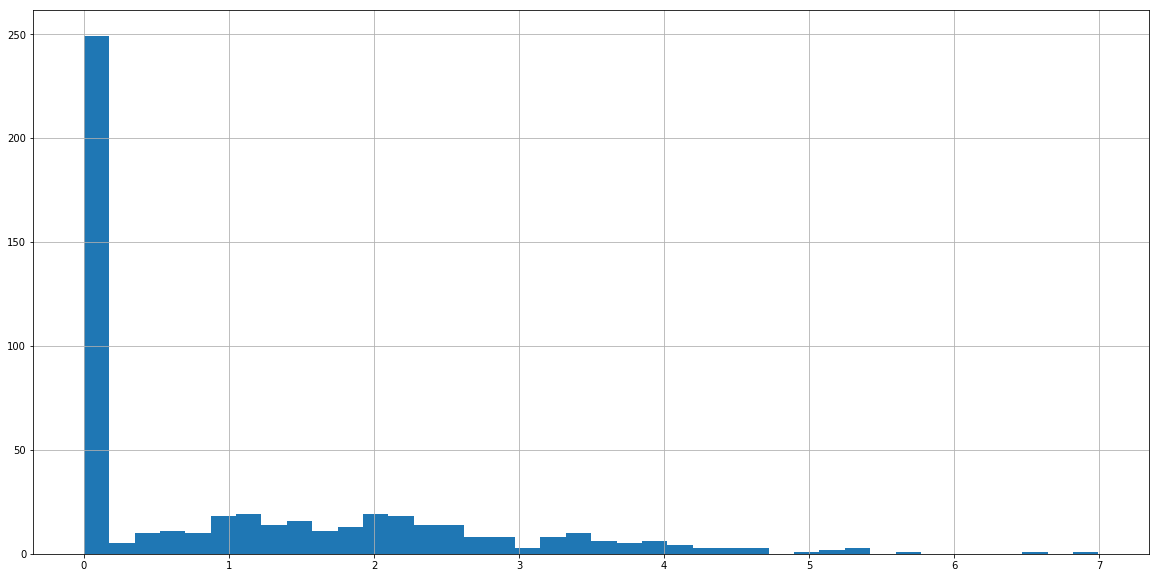

In [5]:
## Explore repsonse variable 'area'
#data2['area'].hist(bins = 40, figsize=(20,10))
#1 - (data2[data2['area'] == 0.0].shape[0]/data2.shape[0]) # for about 52% there is an obs. of a forest fire, 48% 'area' = 0.0

# Distribution of repsonse variable is highly right-skewed so we could apply log transformation
data2['area'] = data2['area'].apply(lambda x: np.log(x+1)) # np.log performs natural log
data2['area'].hist(bins = 40, figsize=(20,10))
data2.rename(index = str, columns = {"area": "log(1+area)"}, inplace = True)
data2.describe()

In [6]:
## all obs. where 'area' != 0.0
data3 = data2[data2['log(1+area)'] != 0.0]
#display(data3.head(30))
data3.shape

(270, 13)

In [7]:
## Checking for outliers 
# Descriptive statistics table
display(data.describe())

# Histograms
#data.hist(bins = 30, figsize=(30,20))

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,3.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,1.000000,0.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,1.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,9.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,12.000000,6.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


In [ ]:
## Scatter Plot Matrix
fig = plt.figure(figsize=(30,30))
ax = fig.subplots()
sm = pd.plotting.scatter_matrix(data2, ax = ax)

In [ ]:
## Correlation 
display(data2.corr())

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.imshow(data2.corr(), cmap = plt.cm.Reds, interpolation = 'nearest')
plt.colorbar()
ticks = [i for i in range(len(data2.columns))]
plt.xticks(ticks, data2.columns, rotation = 'vertical')
plt.yticks(ticks, data2.columns)
plt.show()

# Prediction Model

In [8]:
## Split into train (size = 2/3) and test data using sklearn's train/test splitter function
# data2 into train/test
X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:, 0:12], 
                                                    data2.iloc[:, 12], test_size = 0.33, random_state= 123)
# data3 into train/test
X_train2, X_test2, y_train2, y_test2 = train_test_split(data3.iloc[:, 0:12], 
                                                        data3.iloc[:, 12], test_size = 0.33, random_state= 123)
# PCA
def my_pca(X_train, X_test, n_comp):
    pca = PCA(n_components = n_comp)
    pca.fit(X_train)
    pca_train = pd.DataFrame(pca.transform(X_train))
    pca_test = pd.DataFrame(pca.transform(X_test))
    return (pca_train, pca_test)

X_trainpca, X_testpca = my_pca(X_train, X_test, 12)


# Scalers
scaler = preprocessing.StandardScaler().fit(X_train) # for data2

scaler2 = preprocessing.StandardScaler().fit(X_train2) # for data3

#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

In [13]:
### Regression Models

# Linear Regression
def linear_reg(X_train, y_train, X_test, y_test):
    # Fit model
    reg = LinearRegression().fit(X_train, y_train)
    print(f'R^2 value for model: {reg.score(X_train, y_train)}')
    print(f'Coeffiecients: {reg.coef_}')
    
    # Predict test, compute metrics
    pred = reg.predict(X_test)
    r2_score = reg.score(X_test, y_test)
    rmse = round(math.sqrt(mean_squared_error(y_test, pred)), 5)
    print(f'RMSE: {rmse}')
    print(f'R^2 Score: {r2_score}')
    
    return reg

# Gradient Boosted Trees
def run_boosted_tree(X_train, y_train, X_test, y_test, param_fix, cv, param_grid):
    print("GridSearch initializing...")
    clf = GridSearchCV(estimator = GradientBoostingRegressor(**param_fix), cv = cv, param_grid = param_grid, 
                       scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], 
                       refit = 'neg_mean_squared_error')
    
    print("GradientBoostedRegressor model in training...")
    t0 = time.time()
    clf.fit(X_train, y_train)
    clf_fit = time.time() - t0
    print("GradientBoostedRegressor model selected and fitted in %.3f s\n" % clf_fit)
    
    best_params = clf.best_params_
    print("Best parameters selected by GridSearch: %s" % best_params)
    
    pred = clf.predict(X_test)
    rmse = round(math.sqrt(mean_squared_error(y_test, pred)), 5)
    print(f'RMSE: {rmse}')

    
    return clf

# Support Vector Regression 
def run_svr(X_train, y_train, X_test, y_test, cv, param_grid):
    print("GridSearch initializing...")
    gs = GridSearchCV(estimator = SVR(), cv=cv, param_grid=param_grid, iid=True,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], 
                      refit='neg_mean_squared_error')
    
    print("SVR model in training...")
    gs.fit(X_train, y_train)
          
    best_params = gs.best_params_
    print("Best parameters selected by GridSearch: %s" % best_params)
    
    pred = gs.predict(X_test)
    rmse = round(math.sqrt(mean_squared_error(y_test, pred)), 5)
    print(f'RMSE: {rmse}')
    
    return gs

def run_autoML(X_train, y_train, X_test, y_test):
    h2o.init()
    
    # Create H2O train/test set
    X_train['log(1+area)'] = y_train.values
    train_h20 = h2o.H2OFrame(X_train)
    test_h20 = h2o.H2OFrame(X_test)
    
    # Identify predictors and response
    y = 'log(1+area)'

    # Run AutoML for 30 base models (limited to 1 hour max runtime by default)
    aml = H2OAutoML(max_models=50, max_runtime_secs=600, seed=1)
    aml.train(y=y, training_frame=train_h20)
    
    # View the AutoML Leaderboard
    display('AUTOML Leaderboard')
    lb = aml.leaderboard
    print(lb.head(rows=lb.nrows)) # Print all rows instead of default (10 rows)
    
    # Predict test set
    preds = aml.predict(test_h20)
    preds_array = preds.as_data_frame().as_matrix() # First convert preds to a pandas df, then to a numpy array
    rmse = round(math.sqrt(mean_squared_error(y_test, preds_array)), 5)
    print(f'RMSE: {rmse}')

    return aml

In [39]:
### Linear Regression 

display('### Linear Regression ###')
reg1 = linear_reg(X_train, y_train, X_test, y_test)

display('### Linear Regression w/ Scaled Data ###')
reg = linear_reg(scaler.transform(X_train),y_train, scaler.transform(X_test), y_test)

# Low R^2 value of linear models implies that they are not much better than the baseline model (model consisting of
# intercept only where intercept is the mean of response variable). Similar results for scaled and unscaled data

# Using only meteorological predictors
#reg2 = linear_reg(X_train[['temp', 'RH', 'wind', 'rain']], y_train, X_test[['temp', 'RH', 'wind', 'rain']], y_test)

# 'area' != 0.0
#reg3 = linear_reg(scaler2.transform(X_train2), y_train2, scaler2.transform(X_test2), y_test2)


#display('### Linear Regression w/ PCA ###')
#reg4 = linear_reg(X_trainpca, y_train, X_testpca, y_test)

'### Linear Regression ###'

R^2 value for model: 0.07451358850565404
Coeffiecients: [ 0.08857591  0.05597179  0.06554509 -0.04165653 -0.00020871  0.0006177
 -0.00015392 -0.02170754  0.02822952 -0.00803256  0.10753989  0.02752606]
RMSE: 1.43211
R^2 Score: -0.15565990363413595


'### Linear Regression w/ Scaled Data ###'

R^2 value for model: 0.07451358850565404
Coeffiecients: [ 0.20129656  0.06572508  0.14951786 -0.08452525 -0.00093452  0.03920371
 -0.03851154 -0.10007992  0.16253249 -0.13008135  0.19165877  0.00993241]
RMSE: 1.43211
R^2 Score: -0.1556599036341353


In [12]:
### Gradient Boosted Trees
param_fix =  {'loss': 'ls', 'learning_rate': 0.01}
cv = 10
param_grid = {'n_estimators': (50, 100, 150, 200, 300, 400, 500), 
              'max_depth': (1, 2, 3, 4, 5), 
              'min_samples_split': (2,3,5)}


#display('### Gradient Boosted Trees ###')
#gbr = run_boosted_tree(X_train, y_train, X_test, y_test, param_fix, cv, param_grid)

display('### Gradient Boosted Trees w/ Scaled Data ###')
gbr_s = run_boosted_tree(scaler.transform(X_train), y_train, scaler.transform(X_test), y_test,param_fix, cv, param_grid)

# Best parameters were the same for both models, however, fitting runtime and MSE was slightly lower of model fit 
# on unscaled data. 
# Low R^2 implies that model is not performing well and that we are better of predicting any sample as 
# equal to the mean of response variable

'### Gradient Boosted Trees w/ Scaled Data ###'

GridSearch initializing...
GradientBoostedRegressor model in training...
GradientBoostedRegressor model selected and fitted in 67.832 s

Best parameters selected by GridSearch: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 150}
RMSE: 1.35524


In [ ]:
### SVR
param_grid = {
    'C': np.linspace(.2,1,5),
    'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], # poly very slow
    'epsilon': np.linspace(0,.5,6),
}

#display('### SVR ###')
#svr = run_svr(X_train, y_train, X_test, y_test, cv = 5, param_grid = param_grid)

display('### SVR w/ Scaled Data ###')
svr = run_svr(scaler.transform(X_train), y_train, scaler.transform(X_test), y_test, cv = 5, param_grid = param_grid)

In [14]:
### AutoML

autoML = run_autoML(X_train, y_train, X_test, y_test)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /Users/annanau/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/9z/gcx4w2251dggq9g1f3yhhkfm0000gn/T/tmp0b0kpv54
  JVM stdout: /var/folders/9z/gcx4w2251dggq9g1f3yhhkfm0000gn/T/tmp0b0kpv54/h2o_annanau_started_from_python.out
  JVM stderr: /var/folders/9z/gcx4w2251dggq9g1f3yhhkfm0000gn/T/tmp0b0kpv54/h2o_annanau_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Vienna
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.1
H2O cluster version age:,9 days
H2O cluster name:,H2O_from_python_annanau_xo8ovl
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


'AUTOML Leaderboard'

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
GLM_grid_1_AutoML_20190106_192136_model_1,2.0034,1.41541,2.0034,1.16213,0.647452
GBM_5_AutoML_20190106_192136,2.01179,1.41837,2.01179,1.16702,0.634467
GBM_grid_1_AutoML_20190106_192136_model_8,2.0131,1.41884,2.0131,1.16614,0.635919
GBM_grid_1_AutoML_20190106_192136_model_9,2.03612,1.42693,2.03612,1.17243,0.638769
GBM_grid_1_AutoML_20190106_192136_model_3,2.03963,1.42816,2.03963,1.17373,0.639382
GBM_grid_1_AutoML_20190106_192136_model_2,2.05912,1.43496,2.05912,1.17135,0.643644
XGBoost_grid_1_AutoML_20190106_192136_model_4,2.06419,1.43673,2.06419,1.133,0.615799
XGBoost_grid_1_AutoML_20190106_192136_model_3,2.06499,1.43701,2.06499,1.13872,0.61914
XGBoost_grid_1_AutoML_20190106_192136_model_5,2.06727,1.4378,2.06727,1.14175,0.619994
XGBoost_grid_1_AutoML_20190106_192136_model_7,2.06874,1.43831,2.06874,1.15681,0.631303



glm prediction progress: |████████████████████████████████████████████████| 100%


/Users/annanau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


RMSE: 1.36861


In [ ]:
# shutdown h2o cluster
h2o.cluster().shutdown()